In [1]:
import random,copy,math,time,os,sys

from importlib import reload

# numpy/scipy stuff
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt

sys.path.insert(1, './../')
import simulations.thermodynamic_model as tm
#reload(sims.thermodynamic_model)

# UNCOMMENT IF YOU WANT LATEX IN FIGURES
# from matplotlib import rc
# FONT_SIZE = 20
# rc('font',**{'family':'serif','serif':['CMU Serif']})
# rc('axes', titlesize=FONT_SIZE,labelsize=FONT_SIZE)  
# plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
# plt.rc('legend', fontsize=15) 
# mpl.rcParams['font.size'] = 12
# rc('text', usetex=True)

# %matplotlib inline

# Energy distribution for random sites

Text(0.5, 0, 'Position')

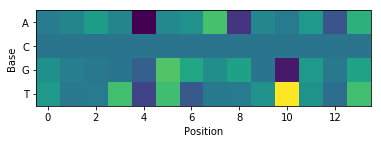

In [2]:
L = 14
# generate energy matrix
# units are in kbT
E = np.random.normal(0.15,0.1,(L,4)) 
E[:,1] = 0.1*np.ones(L)
site = np.random.choice(range(4),L)
plt.imshow(E.T)

# plot
ax = plt.gca()
plt.yticks(np.arange(4), ('A','C','G','T'))
ax.set_ylabel('Base')
ax.set_xlabel('Position')

In [3]:
g_set = [np.random.choice(range(4),L) for k in range(10000)]
E_rand = []
for g in g_set:
    E_sum = np.sum([E[k,g[k]] for k in range(L)])
    E_rand.append(E_sum)

Text(0.5, 0, '$E$')

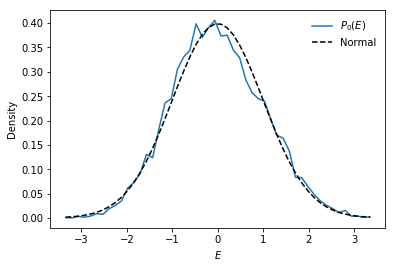

In [4]:
# plot histogram of normalized energy
hist,bins= np.histogram((E_rand-np.mean(E_rand))/np.std(E_rand),50,density=True);
bins = (bins[1:]+bins[:-1])/2
plt.plot(bins,hist,'-',label='$P_0(E)$')

# compare to Guassian
plt.plot(bins,1/np.sqrt(2*np.pi)*np.exp(-bins**2/2),'k--',label='Normal')

# plotting stuff
plt.legend(loc='upper right',frameon=False)
ax = plt.gca()
ax.set_ylabel('Density')
ax.set_xlabel('$E$')

# Energy distribution of site under selection

## Build thermodynamic model using tf_thermodynamic_model class

In [5]:
# I've written a class for working with thermodynamic models of tf evolution. 
# In order to define a model, we need the following paramaters
M_sites = 1 # number of binding sites
M_factors = 1 # number of transcription factors
binding_energies = [E] # binding energy matrices for each tf (a list of M_factors L x 4 arrays)
#binding_energies[0][:,0]= np.ones(L)
interaction_energies = np.array([[0.0]]) # no protien-protien interactions in this mode so don't worry about this 
rates = np.zeros((M_sites,M_factors))  # transcription rates
rates[0,0]= 1.
tf_concentrations = np.array([1.]) # tf concentrations

In [7]:
reload(tm)
model = tm.tf_thermodynamic_model(binding_energies,interaction_energies,rates,tf_concentrations,M_sites)
sel= 0.05 # strength of selection on gene expression at site
def fitness_func(model,g): # use expression level as proxy for fitness
    return sel*model.expression_level(g)

In [8]:
g0 = np.array([np.random.choice(range(4),L) for k in range(M_sites)])

In [9]:
g0 = np.array([np.random.choice(range(4),L) for k in range(M_sites)])
print(g0)
fitness_func(model,g0)

[[1 3 2 2 3 2 1 0 2 1 3 3 2 0]]


0.004316279294667429

## Look at the fitness landscape of random sites

In [10]:
g_set = [np.array([np.random.choice(range(3),L)]*M_sites) for k in range(50)]
f_set = [fitness_func(model,g) for g in g_set]
E_set = [np.sum([binding_energies[0][k,g[0][k]] for k in range(L)]) for g in g_set]

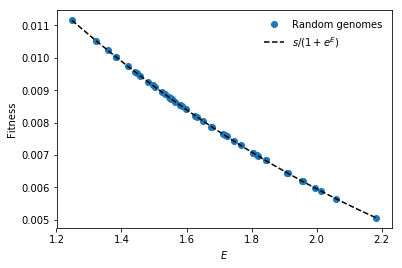

In [11]:
plt.plot(E_set,f_set,'o',label='Random genomes')
x = np.linspace(np.min(E_set),np.max(E_set),100)
plt.plot(x,sel/(1+np.exp(x)),'k--',label=r'$s/(1+e^E)$')
ax = plt.gca()
ax.set_xlabel(r'$E$')
ax.set_ylabel('Fitness')
plt.legend(loc='upper right',frameon=False)

## Run stochastic simulations in SSWM regime

In [12]:
ne = 1000
tmax = 500
trajectory = model.substitution_evolution(tmax,g0,fitness_func,0.2,ne)

In [25]:
t = np.array(trajectory.time)
g = trajectory.genotypes

In [22]:
help(model.substitution_evolution)

Help on method substitution_evolution in module thermodynamic_model:

substitution_evolution(tmax, g, fitness_func, p_mut, ne, *, max_steps=1000000) method of thermodynamic_model.tf_thermodynamic_model instance
    Simulate the evolutionary dynamics in the strong selection, weak mutation
    regime. In this limit we don't need to simulate the full moran process,
    instead, we simply compute the time until the next mutation
    arrises and sweeps the population. We will use Gillespie's algorithm to
    find the jump times and substitutions to make
    
    Input:
    
    g           - the initial genotype (we assume the population is always clonal)
    fitness_fun - maps the fitness to the genotype
    p_mut       - mutation rate, assumed to be the same for all sites
    ne          - the effective population size
    
    Output:
    
    t - the times at which new mutations fixate
    G - the genomes at each step



In [23]:
f_path = [fitness_func(model,gt.reshape((M_sites,L))) for gt in g ]
E_path = [np.sum([E[k,gt.reshape((M_sites,L))[0,k]] for k in range(L)]) for gt in g ]

In [24]:
plt.semilogx(t,f_path,'-',alpha=0.9)
ax = plt.gca()
ax.set_xlabel('Time')
ax.set_ylabel('Fitness')

NameError: name 't' is not defined

Text(0, 0.5, 'Energy')

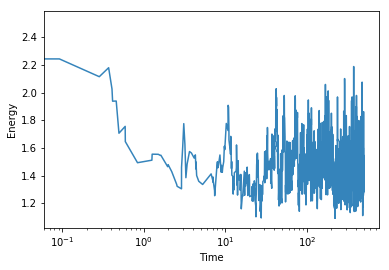

In [15]:
plt.semilogx(t,E_path,'-',alpha=0.9)
ax = plt.gca()
ax.set_xlabel('Time')
ax.set_ylabel('Energy')

## Compare inferred fitness landscape to analytical formula

In [16]:
E_stat = E_path[200:] # get the stationary distribution by ignoring the initial transient 
E_all= E_stat+E_rand
bins = np.linspace(np.min(E_rand),np.max(E_stat),40)
hist,x= np.histogram(E_stat,bins,density=True);
hist_rand,x= np.histogram(E_rand,bins,density=True);
x = (bins[1:]+bins[:-1])/2

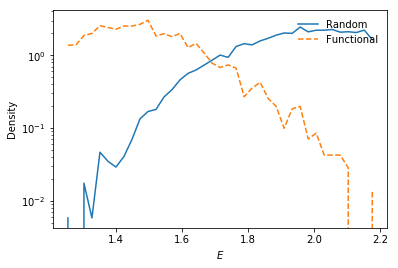

In [17]:
plt.plot(x,hist_rand,label='Random')
plt.semilogy(x,hist,'--',label='Functional')
ax = plt.gca()
ax.set_xlabel(r'$E$')
ax.set_ylabel('Density')
plt.legend(loc='upper right',frameon=False)

/Users/E/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/E/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


[]

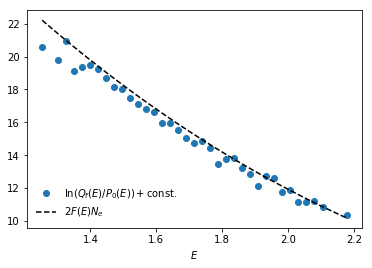

In [18]:
const = np.log(hist[3]/hist_rand[3]) - 2*sel*ne/(1+np.exp(x[3]))
plt.plot(x,np.log(hist/hist_rand)-const,'o',label =r'$\ln(Q_f(E)/P_0(E))+{\rm const.}$')
plt.plot(x,2*sel*ne/(1+np.exp(x)),'k--',label =r'$2F(E)N_e$')
ax = plt.gca()
ax.set_xlabel(r'$E$')
plt.legend(loc='lower left',frameon=False)
plt.plot()

In [19]:
#print(pd.__version__)
print(np.__version__)

1.16.2
